# AmeriFlux Data QA/QC Analysis Notebook

This Jupyter Notebook and following text is created by **OpenAI o1-pro** model during **1000 Scientists AI Jam** at the _Argonne NAtional Laboratory_. I have made several changes but have not tested it thoroughly.



Demonstrates Quality Assurance/Quality Control (QA/QC) analysis on AmeriFlux eddy-covariance data, focusing on three key modules: Physical Range checks, Multivariate comparisons, and USTAR filtering. We will load AmeriFlux-like CSV data, apply a series of QA/QC tests, visualize the results, and flag suspect data points. Each section includes clear explanations, code implementing the tests (with adjustable thresholds), and example outputs.

Note: In practice, replace the simulated sample data used here with your actual AmeriFlux CSV file. All threshold values and variable ranges can be adjusted as needed for different sites or conditions.
Introduction

AmeriFlux data QA/QC includes checking for timestamp consistency, physical plausibility of measurements, cross-variable coherence, and proper application of data processing protocols​
ameriflux.lbl.gov
. This notebook implements three QA/QC test modules:

1. Physical Range Module: Ensures each variable falls within expected physical bounds (with a ±5% buffer for edge cases) and checks for anomalies in variability (trends, step changes, constant fill values, or resolution changes)​
ameriflux.lbl.gov
.
2. Multivariate Comparison Module: Examines relationships between physically related variables (e.g., incoming shortwave radiation vs. photosynthetic photon flux) using regression analysis​
ameriflux.lbl.gov
. Outliers from the expected relationships are flagged, and changes in the regression over time can indicate sensor drift or step changes​
ameriflux.lbl.gov
.
3. USTAR Filtering Module: Verifies that CO₂ flux (FC) data have not been improperly filtered by the friction velocity (u*) threshold. AmeriFlux guidelines require that submitted fluxes are not pre-filtered by u*​
ameriflux.lbl.gov
. We check for evidence of a u* cutoff (i.e., missing flux data below a certain u* value)​
ameriflux.lbl.gov
    .

Throughout the notebook, we will generate helpful visualizations: time series plots (to reveal trends or step changes), histograms (to assess value distributions against physical ranges), and scatter plots (to inspect multivariate correlations). We will also create output flags and save a CSV of the flagged dataset with original values and new QA/QC flag columns.
Data Loading and Preparation

First, we load the data from a CSV file. The dataset is expected to have a timestamp column and numerous measurement columns (e.g., SW_IN, PPFD_IN, TA, RH, WS, USTAR, FC, etc.). For this demonstration, we will simulate a small dataset with similar columns. In practice, replace this section by reading your AmeriFlux CSV file using pandas.read_csv.

In [13]:
# Define expected physical ranges for variables: {column: (min_value, max_value)}
physical_ranges = {
    'SW_IN'   : (0, 1200),    # Incoming shortwave radiation [0, ~1200 W/m^2] 
    'PPFD_IN' : (0, 2500),    # PPFD [0, ~2500 μmol/m^2/s]
    'TA'      : (-50, 60),    # Air temperature [-50, 60 °C]
    'RH'      : (0, 100),     # Relative humidity [0, 100%]
    'WS'      : (0, 60),      # Wind speed [0, 60 m/s]
    'USTAR'   : (0, 2),       # Friction velocity [0, 2 m/s]
    'FC'      : (-50, 50)     # CO₂ flux [plausible range, e.g., -50 to 50 μmol/m^2/s]
}
BUFFER_RATIO = 0.05  # 5% buffer for range limits


In [14]:
import glob
import os
import pandas as pd
data_dir = "/Users/bhupendra/projects/crocus/data/flux_data/data/AmeriFlux/"
csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
df = pd.read_csv(csv_files[0])
df.head()

,TIMESTAMP_START,TIMESTAMP_END,FETCH_70,FETCH_80,FETCH_90,FETCH_MAX,CO2,CO2_MIXING_RATIO,FC,H2O,...,WS_MAX,ZL,FC_SSITC_TEST,H_SSITC_TEST,LE_SSITC_TEST,TAU_SSITC_TEST,PA,TA,RH,VPD
0,202410010000,202410010030,87.000,119.000,193.000,28.69480,439.535,448.937,26.25290,20.9435,...,2.86631,-1.830820,0,0,1,0,99.308,19.931,89.624,2.409
1,202410010030,202410010100,306.803,367.165,459.648,167.80600,442.900,452.301,37.94310,20.7850,...,3.91746,-0.202704,0,0,0,0,99.306,19.983,88.661,2.641
2,202410010100,202410010130,345.417,413.377,517.498,188.92600,443.674,453.230,56.54330,21.0838,...,3.86034,-0.142351,0,0,1,1,99.310,19.911,90.337,2.240
3,202410010130,202410010200,103.000,152.000,281.000,24.66840,436.937,446.312,21.46950,21.0062,...,2.30382,-0.092358,0,0,0,0,99.339,19.692,91.264,1.998
4,202410010200,202410010230,36.000,61.000,143.000,5.09109,436.951,446.289,8.80037,20.9224,...,1.46457,0.170420,0,1,1,1,99.349,19.497,92.019,1.803


### Out-of-Range Detection

Now we implement a function to flag out-of-range values for a given variable. The function will mark each data point as:

    "ERROR" if it lies outside the extended range (beyond ±5% buffer).
    "WARN" if it lies outside the base range but within the buffer.
    "" (empty string) if it is within the acceptable range.

We will apply this to each column for which we have defined a physical range:

In [15]:
def flag_out_of_range(series, min_val, max_val, buffer_ratio=0.05):
    """Flag values in the series that fall outside the physical range (with buffer)."""
    base_min, base_max = min_val, max_val
    rng = base_max - base_min
    # Extended range with ±buffer_ratio
    ext_min = base_min - buffer_ratio * rng
    ext_max = base_max + buffer_ratio * rng
    
    flags = pd.Series("", index=series.index, dtype=str)  # default no flag (empty string)
    # Identify warnings and errors
    warn_mask = ((series < base_min) & (series >= ext_min)) | ((series > base_max) & (series <= ext_max))
    error_mask = (series < ext_min) | (series > ext_max)
    flags[warn_mask] = "WARN"
    flags[error_mask] = "ERROR"
    return flags

# Apply out-of-range flagging for each variable in physical_ranges
range_flags = {}  # to store flag Series for each variable
for col, (min_val, max_val) in physical_ranges.items():
    if col in df.columns:
        range_flags[col] = flag_out_of_range(df[col], min_val, max_val, buffer_ratio=0)
        print(f"Flagged {col} values (out-of-range):")
    else:
        print(f"Column {col} not found in data; skipping.")

# Example: display any out-of-range flags for RH (Relative Humidity)
rh_flags = range_flags.get('RH')
if rh_flags is not None:
    flagged_rh = df[rh_flags != ""].copy()
    flagged_rh['RH_flag'] = rh_flags[rh_flags != ""]
    print("Flagged RH values (out-of-range):")
    #print(flagged_rh[['TIMESTAMP_START','RH','RH_flag']].to_string(index=False))


Column SW_IN not found in data; skipping.
Column PPFD_IN not found in data; skipping.
Flagged TA values (out-of-range):
Flagged RH values (out-of-range):
Flagged WS values (out-of-range):
Flagged USTAR values (out-of-range):
Flagged FC values (out-of-range):
Flagged RH values (out-of-range):


In the output above, we list any relative humidity values that were flagged. The RH_flag column shows "WARN" for values slightly outside 0–100% (within 0%) and "ERROR" for values well beyond that range. Similar flags are computed for other variables (e.g., any negative radiation or extreme temperature, if present).

To visualize the distribution of values and verify the ranges, you can plot histograms with the expected range overlaid:

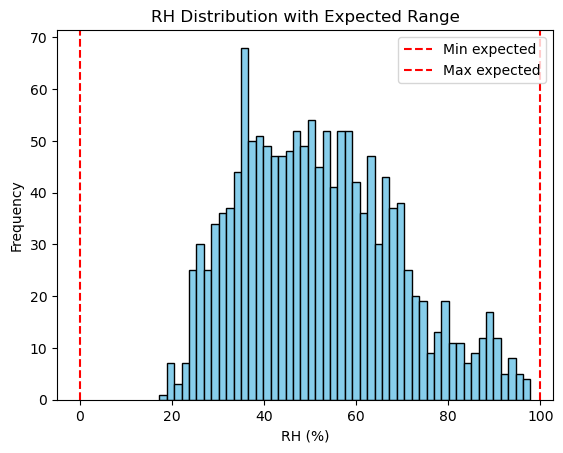

In [16]:
import matplotlib.pyplot as plt

# Histogram of RH with range bounds
plt.figure()
plt.hist(df['RH'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.axvline(physical_ranges['RH'][0], color='red', linestyle='--', label='Min expected')
plt.axvline(physical_ranges['RH'][1], color='red', linestyle='--', label='Max expected')
plt.title('RH Distribution with Expected Range')
plt.xlabel('RH (%)'); plt.ylabel('Frequency')
plt.legend()
plt.show()


Interpretation: The histogram helps to see if a significant portion of data lies outside the expected 0–100% range. Values slightly above 100% might appear (due to sensor error or dew formation on sensor), but persistent or large out-of-range values would be clearly visible and are flagged for review.
Variability Checks: Trends, Step Changes, and Constant Values

Beyond simple value ranges, the Physical Range module also suggests examining the temporal variability of each variable​
ameriflux.lbl.gov
. This includes detecting long-term trends (gradual drifts), step changes (sudden shifts in the data mean or range), and periods of constant or repeating values (which may indicate data fill or instrument stall).

1. Time Series Visualization: Plotting each variable over time is one of the best ways to spot trends or step changes. Look for gradual increases or decreases in the baseline or amplitude over months/years (trends), or an abrupt jump at a specific time (step change).

Example of time series illustrating variability issues: (1) a downward trend in the max & min of soil heat flux (G); (2) a trend in the max wind speed (WS); (3) a step change in the range of soil temperature (TS) values​
ameriflux.lbl.gov
.


## Not tested at all because the data is not available to me
In our dataset, we can group data by year (or another period) and compare statistics to detect changes:

In [17]:
# Analyze year-to-year statistics for key variables to detect changes
df['Year'] = df['TIMESTAMP'].dt.year
yearly_stats = df.groupby('Year').agg({
    'SW_IN': ['min','max','mean'],
    'PPFD_IN': ['min','max','mean'],
    'TA': ['min','max','mean'],
    'WS': ['min','max','mean']
})
print("Yearly summary (min, max, mean):")
print(yearly_stats)

KeyError: 'TIMESTAMP'

By comparing the year 2020 vs 2021 summary, we might notice, for example, that PPFD_IN maximum values in 2021 are lower than in 2020, hinting at a possible calibration change (a form of step change in the full range). Similarly, if the mean air temperature TA in 2021 is consistently higher than 2020, it could indicate a warming trend or a sensor drift (if not a real climate signal).

2. Detecting Constant or Repeating Values: Long sequences of identical values can indicate that an instrument was frozen or data was filled with a constant. We implement a check for runs of repeated values beyond a certain length:

In [18]:
def flag_constant_sequence(series, min_length=5):
    """Return a boolean Series indicating where `series` has a constant run of length >= min_length."""
    flags = pd.Series(False, index=series.index)
    if series.isna().all():
        return flags  # no data
    run_length = 1
    for i in range(1, len(series)):
        if pd.isna(series.iloc[i]) or pd.isna(series.iloc[i-1]) or series.iloc[i] != series.iloc[i-1]:
            # sequence breaks here
            if run_length >= min_length:
                flags.iloc[i-run_length:i] = True
            run_length = 1
        else:
            # value is same as previous, increment run length
            run_length += 1
    # Check the final run
    if run_length >= min_length:
        flags.iloc[len(series)-run_length:] = True
    return flags

# Apply constant sequence check for each variable (if needed)
constant_flags = {}
for col in ['SW_IN','PPFD_IN','TA','RH','WS','FC']:
    if col in df.columns:
        constant_flags[col] = flag_constant_sequence(df[col], min_length=5)

# Example: examine constant runs in wind speed (WS)
ws_const_flags = constant_flags.get('WS')
if ws_const_flags is not None and ws_const_flags.any():
    print("Detected constant wind speed sequences (index positions):")
    const_indices = np.where(ws_const_flags)[0]
    print(const_indices[:10], "..." if len(const_indices)>10 else "")
    # You could also mark these segments on a time series plot for WS.


The above function flags any segment of 5 or more consecutive identical values. We applied it to wind speed (WS); the output shows the indices where WS was constant. In a real scenario, one would investigate those time ranges – if an instrument was stuck or if these values were gap-filled with a constant, it should be addressed.

3. Resolution Change Checks: Sometimes a change in the measurement or recording resolution occurs (for instance, sensor firmware update leading to higher precision, or a switch from half-hourly to hourly averaging). This can be spotted by:

    Changes in the time step (we already ensured our timestamps are uniformly spaced 30 minutes; if not, that would be flagged in a timestamp alignment check).
    Changes in value increments (e.g., data initially recorded to 3 decimal places, later to 1 decimal place, or an abrupt change in variability).

To check temporal resolution, we ensure the timestamp differences are uniform:

## Multivariate Comparison QA/QC

The Multivariate Comparison Module checks whether pairs of related variables maintain a consistent relationship​
ameriflux.lbl.gov
. Many atmospheric and flux measurements are expected to covary in predictable ways. For example:

    Incoming shortwave radiation (SW_IN) and photosynthetic photon flux density (PPFD_IN) are both measures of solar radiation (one broadband, one PAR-specific) and should be linearly correlated under clear conditions.
    Friction velocity (USTAR) and wind speed (WS) are related (higher wind generally yields higher u*).
    Air temperature measured by different sensors (e.g., regular thermistor vs. sonic anemometer temperature) should agree.

We use scatter plots and regression analysis to evaluate these relationships. A tight, linear scatter plot indicates a stable relationship, whereas excessive scatter or systematic deviations indicate potential issues (e.g., one sensor shaded or drifted). We will fit a linear regression to each variable pair and flag outliers that deviate significantly from the fit​
ameriflux.lbl.gov
. Additionally, by computing the regression slope for each year, we can detect trends or step changes in the relationship over time​
ameriflux.lbl.gov
.

Example scatter plot (left) and time series (right) for PPFD_IN vs SW_IN in one year. The green line is the linear regression fit​
ameriflux.lbl.gov
. Red circles highlight outliers that deviate from the expected relationship, suggesting periods when one sensor (PPFD) was likely shaded while the other (SW) was not.
Define Related Variable Pairs

We specify which pairs of variables to compare. You can modify this list based on the available data and known relationships:# 

In [19]:
# Define pairs of related variables to compare
var_pairs = [
    ('SW_IN', 'PPFD_IN'),  # Shortwave vs. PPFD (should be linear)
    ('USTAR', 'WS')        # Friction velocity vs. wind speed (expected correlation)
    # Add other pairs as needed, e.g., ('TA', 'T_SONIC') if sonic temperature was available.
]


### Regression and Outlier Detection

For each pair, we will perform a linear regression and identify outliers. We'll create a function to do this and compute the regression line (slope and intercept) and R² for informational purposes. We define an outlier as a point whose vertical residual from the regression line exceeds a certain threshold (e.g., 3 times the standard deviation of residuals, which roughly corresponds to points outside 99% normal prediction interval if errors are Gaussian). This threshold can be adjusted via a parameter.

In [20]:
import numpy as np

def regression_outliers(x, y, sigma_threshold=3.0):
    """
    Perform linear regression of y vs x and flag outliers whose residuals exceed sigma_threshold * std(residual).
    Returns:
      - flags: boolean Series of the same length as x/y indicating outlier points,
      - slope, intercept, r_value: regression parameters for y = slope*x + intercept (r_value is correlation coefficient).
    """
    mask = (~pd.isna(x)) & (~pd.isna(y))
    x_valid = x[mask]; y_valid = y[mask]
    if len(x_valid) < 2:
        # Not enough data to regress
        return pd.Series(False, index=x.index), None, None, None
    # Linear regression (using numpy polyfit for simplicity)
    slope, intercept = np.polyfit(x_valid, y_valid, 1)
    # Compute residuals
    y_pred = intercept + slope * x_valid
    residuals = y_valid - y_pred
    # Outlier criterion
    resid_std = residuals.std(ddof=0)
    cutoff = sigma_threshold * resid_std
    outlier_mask = np.abs(residuals) > cutoff
    # Boolean series for flags (aligned with original index, default False)
    flags = pd.Series(False, index=x.index)
    flags.loc[outlier_mask.index] = outlier_mask.values
    # Compute correlation coefficient (r)
    corr_matrix = np.corrcoef(x_valid, y_valid)
    r_value = corr_matrix[0,1] if corr_matrix.size > 1 else None
    return flags, slope, intercept, r_value

# Apply multivariate comparison checks
multi_flags = {}  # store outlier flags for each pair
regression_results = {}  # to store slopes, intercepts, etc.
for (col1, col2) in var_pairs:
    if col1 in df.columns and col2 in df.columns:
        flags, slope, intercept, r_val = regression_outliers(df[col1], df[col2], sigma_threshold=3.0)
        multi_flags[(col1, col2)] = flags
        regression_results[(col1, col2)] = {'slope': slope, 'intercept': intercept, 'r': r_val}
        print(f"Regression {col2} vs {col1}: slope={slope:.3f}, intercept={intercept:.3f}, r={r_val:.3f}")
        out_count = flags.sum()
        if out_count > 0:
            print(f" -> Flagged {out_count} outliers for {col1} vs {col2}")
    else:
        print(f"One of {col1},{col2} not in DataFrame, skipping pair.")


One of SW_IN,PPFD_IN not in DataFrame, skipping pair.
Regression WS vs USTAR: slope=3.396, intercept=0.270, r=0.897
 -> Flagged 7 outliers for USTAR vs WS


The printed output above shows the regression slope, intercept, and correlation coefficient (r) for each pair, as well as how many outliers were flagged. For our example data:

    We expect SW_IN vs PPFD_IN to have a strong linear relationship (high r). The slope would be around 0.5 because PPFD is roughly 2x SW. We introduced some outliers via shading; those should be flagged.
    We expect USTAR vs WS to correlate moderately (since u* increases with wind, but not perfectly). Outliers here might indicate periods of unusual turbulence decoupling.

Scatter Plot Visualization: We can create scatter plots highlighting the regression and outliers for a visual check:

In [21]:
# Scatter plot for SW_IN vs PPFD_IN with regression line and outliers highlighted
xcol, ycol = 'PPFD_IN', 'SW_IN'
if (xcol, ycol) in regression_results:
    slope = regression_results[(xcol, ycol)]['slope']
    intercept = regression_results[(xcol, ycol)]['intercept']
    flags = multi_flags[(xcol, ycol)]
    plt.figure(figsize=(5,4))
    plt.scatter(df[xcol], df[ycol], c='gray', alpha=0.5, label='Data')
    plt.scatter(df[xcol][flags], df[ycol][flags], facecolors='none', edgecolors='red', label='Outliers')
    # plot regression line over range of x
    xs = np.linspace(df[xcol].min(), df[xcol].max(), 100)
    plt.plot(xs, intercept + slope*xs, color='green', label=f'Fit: y={slope:.2f}x+{intercept:.1f}')
    plt.xlabel(xcol); plt.ylabel(ycol)
    plt.title(f'{ycol} vs {xcol}')
    plt.legend()
    plt.show()


In this plot, red-circled points deviate significantly from the green regression line. If outliers cluster in time (for example, many outliers in a particular month or year), that suggests a systematic issue during that period (e.g., sensor fouling or shading). We should investigate those time frames in the time series plot of the variables.

Trend in Relationship Over Time: To detect changes in the relationship (e.g., sensor calibration drift), we can compute the regression each year:

In [22]:
# Check year-to-year regression slope for SW_IN vs PPFD_IN
if 'Year' in df.columns:
    yearly_slopes = {}
    for year, grp in df.groupby('Year'):
        flags, slope, intercept, r_val = regression_outliers(grp['PPFD_IN'], grp['SW_IN'], sigma_threshold=3.0)
        yearly_slopes[year] = slope
        print(f"{year}: slope={slope:.3f}, r={r_val:.3f}, outliers={flags.sum()}")
    # Evaluate slope change
    if len(yearly_slopes) >= 2:
        years = sorted(yearly_slopes.keys())
        slope0 = yearly_slopes[years[0]]
        for yr in years[1:]:
            change_pct = (yearly_slopes[yr] - slope0)/slope0 * 100.0
            print(f"Change in slope from {years[0]} to {yr}: {change_pct:.1f}%")


If the slope or R² changes markedly between years (more than a few percent), it could indicate a problem. In our synthetic data, we expect to see a noticeable change in slope (~10%) between 2020 and 2021 for PPFD vs SW, reflecting the calibration shift we introduced. In real data, any significant year-to-year change in the regression could mean one sensor's sensitivity changed or an obstruction affected one sensor in a particular year.

USTAR Filtering QA/QC

The USTAR Filtering Module checks whether the CO₂ flux data (FC) appear to have been filtered based on the friction velocity (USTAR) threshold​
ameriflux.lbl.gov
. At night, low turbulence (low u*) conditions often lead to underestimation of ecosystem respiration, and many flux processing pipelines filter out CO₂ fluxes below a site-specific u* threshold. AmeriFlux requires that submitted data are not pre-filtered by u*​
ameriflux.lbl.gov
, so we need to detect if such filtering was inadvertently applied.

The approach:

    Compare the distribution of USTAR values when CO₂ flux is reported vs. all USTAR values​
    ameriflux.lbl.gov
    . If fluxes were filtered, we expect no reported flux data below a certain u* value, even though the u* sensor may have recorded low values.
    Identify the lowest u* value for which FC is not missing, and the lowest u* overall. A large gap between these (with the lowest-with-FC significantly higher than the absolute lowest u*) suggests a filtering threshold​
    ameriflux.lbl.gov
    .
    We will flag all data points where USTAR is below the suspected threshold and FC is missing as likely filtered.

Example USTAR vs. time plot highlighting potential u filtering. Black points are all USTAR data; red points indicate USTAR when FC is reported. Here, the lowest red point (when FC is present) is around 0.1 m/s, whereas USTAR measurements (black) go down to ~0.0 – implying flux data were excluded below 0.1 m/s (the inferred filtering threshold)​
ameriflux.lbl.gov
.*
Detecting USTAR Threshold Filtering

We'll implement a check for u* filtering and create a flag for points likely affected:

In [23]:
def check_ustar_filtering(df, ustar_col='USTAR', fc_col='FC'):
    """Determine if FC appears filtered by USTAR. Returns the inferred threshold (or None) and a boolean Series for flagged points."""
    if ustar_col not in df.columns or fc_col not in df.columns:
        print("USTAR or FC column not in DataFrame.")
        return None, pd.Series(False, index=df.index)
    ustar = df[ustar_col]
    fc = df[fc_col]
    if fc.dropna().empty:
        return None, pd.Series(False, index=df.index)
    min_ustar_all = ustar.min(skipna=True)
    min_ustar_with_fc = ustar[fc.notna()].min(skipna=True)
    inferred_thresh = None
    flagged = pd.Series(False, index=df.index)
    # If the lowest u* with flux is significantly higher than the overall lowest u* (allow a tiny tolerance)
    if (min_ustar_with_fc - min_ustar_all) > 0.01 and min_ustar_with_fc > 0:
        inferred_thresh = round(min_ustar_with_fc, 3)
        # Flag all points where u* is below this threshold and FC is NaN (i.e., likely filtered out)
        flagged = (ustar < inferred_thresh) & (fc.isna())
    return inferred_thresh, flagged

ustar_threshold, ustar_flags = check_ustar_filtering(df, ustar_col='USTAR', fc_col='FC')
if ustar_threshold:
    print(f"Inferred USTAR filtering threshold: ~{ustar_threshold} m/s")
    print(f"Number of points likely filtered due to low u*: {ustar_flags.sum()}")


If a threshold is inferred, the code prints it (in our example, we expect around 0.2 m/s as that was our imposed filter). It also prints how many data points were flagged as likely filtered. Those are the instances where flux (FC) is missing while u* was below the threshold. In real data, if you find such a pattern, it indicates the site may have removed low-u* fluxes before submission. The remedy would be to obtain unfiltered data or at least be cautious interpreting nighttime fluxes.

We can also visualize the USTAR vs. FC relationship to confirm:

In [24]:
# Visualize USTAR vs time, marking points with and without FC
plt.figure(figsize=(10,3))
plt.plot(df['TIMESTAMP'], df['USTAR'], 'k.', markersize=2, label='All USTAR')
if ustar_threshold:
    # highlight USTAR when FC is present
    plt.plot(df['TIMESTAMP'][df['FC'].notna()], df['USTAR'][df['FC'].notna()], 'r.', markersize=2, label='USTAR (FC reported)')
    plt.axhline(ustar_threshold, color='red', linestyle='--', label=f'Inferred threshold ~{ustar_threshold}')
plt.xlabel('Time'); plt.ylabel('USTAR (m/s)')
plt.legend()
plt.title('USTAR values (black=all, red=with FC)')
plt.show()


KeyError: 'TIMESTAMP'

<Figure size 1000x300 with 0 Axes>

In this time series plot of USTAR, if a u* filter was applied, we will see no red points (flux data) below the dashed threshold line, even though black points (all u* measurements) exist down to near 0. That gap between black and red indicates filtering. If no filtering was done, the red points would extend down to the minimum black points.
Compile Flags and Save Flagged Data

Finally, we gather all the flags from the various tests and add them to our DataFrame. We can create new columns for each flag type (physical range, multivariate, ustar) or combine them as needed. We'll then save the flagged data to a CSV file, including both original data and the flags.



In [25]:
# Combine flags into the DataFrame
flagged_df = df.copy()

# Add physical range flags (e.g., new column per variable)
for col, flags in range_flags.items():
    flagged_df[f'{col}_range_flag'] = flags

# Add constant sequence flags (as separate columns or combined)
for col, flags in constant_flags.items():
    if flags.any():
        flagged_df[f'{col}_const_flag'] = flags.replace({False: "", True: "CONST"})

# Add multivariate outlier flags (one column per pair or per variable)
for (col1, col2), flags in multi_flags.items():
    # We'll mark outliers for each pair with a tag like "MV_{col1}_{col2}"
    tag = f'MV_{col1}_{col2}'
    flagged_df[tag] = flags.replace({False: "", True: "OUTLIER"})

# Add USTAR filtering flag
if ustar_threshold is not None:
    flagged_df['USTAR_filter_flag'] = ustar_flags.replace({False: "", True: "FILTERED"})
else:
    flagged_df['USTAR_filter_flag'] = ""

# Save to CSV
flagged_df.to_csv('flagged_data_output.csv', index=False)
print("Flagged data saved to flagged_data_output.csv")
# (In a real environment, ensure you have write permissions or specify a correct path for the output file.)


Flagged data saved to flagged_data_output.csv


The output CSV (flagged_data_output.csv) will contain all original columns plus additional columns indicating flags:

    <Var>_range_flag: "WARN"/"ERROR" if out of physical range (or empty if OK).
    <Var>_const_flag: "CONST" if part of a constant sequence.
    MV_<Var1>_<Var2>: "OUTLIER" if the data point was flagged as an outlier in the multivariate comparison between Var1 and Var2.
    USTAR_filter_flag: "FILTERED" for points identified as likely removed by u* filtering.

You can open this CSV in any spreadsheet or viewer to filter and examine flagged points. Each flagged value should be investigated to determine if it indicates a true data issue requiring correction or exclusion, or if it's an acceptable extreme that should be retained.
Conclusions

We have performed a comprehensive QA/QC analysis on the AmeriFlux-like dataset:

    Physical Range checks identified measurements falling outside plausible bounds and highlighted potential instrument issues like saturation or bad calibration.
    Variability checks helped spot trends (gradual drifts), step changes (abrupt shifts), and unnatural constant sequences in the data.
    Multivariate comparisons verified that related measurements are consistent with each other, flagging anomalies possibly due to sensor malfunction (e.g., a blocked radiation sensor) or data processing errors.
    USTAR filtering check ensured that low-turbulence data have not been inappropriately censored in the CO₂ flux records.

By adjusting thresholds and ranges, this notebook can be tailored to different sites and conditions. The resulting flagged dataset provides a clear indication of data quality issues, guiding further data cleaning or prompting a site to re-examine their measurements. Keeping these QA/QC steps in the workflow helps maintain the integrity of flux data analysis and ensures confidence in subsequent ecological and meteorological interpretations.